In [31]:
# Basic import
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.misc
from datetime import datetime

import tensorflow as tf

if not os.path.exists('facenet'):
  !git clone https://github.com/davidsandberg/facenet --depth=1

sys.path.insert(0, './facenet/src')
import align.detect_face
import facenet
import scipy.spatial.distance as distance

from IPython.display import Image, display

In [2]:
model_dir = '/home/sabrine/notebook/reid/20170216-091149/'

In [3]:
# starting a session
tf.reset_default_graph()

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True

sess = tf.Session(config=tf_config)

print('loading the detection/alignment network...')
pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
print('done!')

print('loading the embedding network...')
meta_file, ckpt_file = facenet.get_model_filenames(model_dir)
restorer = tf.train.import_meta_graph(os.path.join(model_dir, meta_file))
restorer.restore(sess, os.path.join(model_dir, ckpt_file))
print('done!')

# getting input / output tensors
g = tf.get_default_graph()
images_in = g.get_tensor_by_name('input:0')
phase_train_in = g.get_tensor_by_name('phase_train:0')
embeddings = g.get_tensor_by_name('embeddings:0')


loading the detection/alignment network...
done!
loading the embedding network...
done!


In [12]:
pathsKnown = ["/home/sabrine/Pictures/cvPic.jpg"]

In [13]:
len(paths)

1

detecting faces...


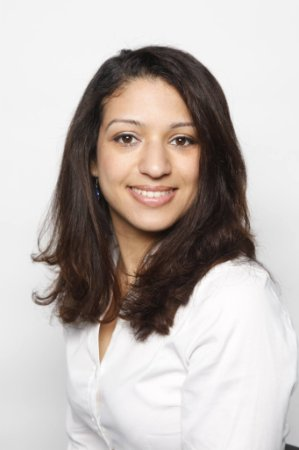

(10, 1)
done!


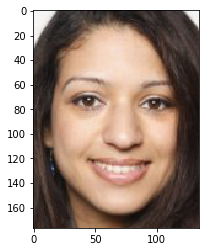

In [27]:
# detection parameters
minsize = 20 
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709
 
# Creation of an array of embedding known faces and an array of faces (image cropped to the center of the face detection) 
# with the same index as the embedding array
knownBoxes = []
knownKeypoints = []
knownFace = []
print('detecting faces...')
for path in pathsKnown:
    display(Image(path))
    img = scipy.misc.imread(path)
    bbs, kps = align.detect_face.detect_face(img, minsize, 
                                             pnet, rnet, onet, threshold, factor)
    kps = np.asarray(kps)
    print(kps.shape)
    kps = kps.reshape([2,5,-1]).T
    
    # Check if a face has been detected
    if len(kps) != 0:  
        # add the image in the face array
        knownFace.append(img)
        knownBoxes.append(bbs)
        knownKeypoints.append(kps)
        
        # Display the face only in order to check if the face was corretly detected
        margin = 32
        # Extract the position of the face from bbs
        for x0,y0,x1,y1,_ in bbs.astype(np.int32):
            x0 = np.maximum(x0 - margin//2, 0)
            y0 = np.maximum(y0 - margin//2, 0)
            x1 = np.minimum(x1 + margin//2, img.shape[1])
            y1 = np.minimum(y1 + margin//2, img.shape[0])
            plt.imshow(img[y0:y1,x0:x1])
                 
print('done!')  

In [29]:
# Computation of the embeddings for known faces
print('computing embeddings')
size = 160
margin = 32

# Creation of the future array of embeddings for known faces and the corresponding cropped faces for checking purpose
knownFaces_embs = []
knownCropped = []

# Fill arrays
for img, bbs in zip(knownFace, knownBoxes):
    img_faces = []
    # Cropped faces
    for x0,y0,x1,y1,_ in bbs.astype(np.int32):
        x0 = np.maximum(x0 - margin//2, 0)
        y0 = np.maximum(y0 - margin//2, 0)
        x1 = np.minimum(x1 + margin//2, img.shape[1])
        y1 = np.minimum(y1 + margin//2, img.shape[0])
    img_faces.append(scipy.misc.imresize(img[y0:y1,x0:x1], (size, size)))
    img_faces = np.stack(img_faces)
    knownCropped.append(img_faces)
  
    # Embeddings
    feed_dict = {
        images_in : img_faces.astype(np.float32) / 255.0,
        phase_train_in : False,
    }
    knownFaces_embs.append(sess.run(embeddings, feed_dict))
print('done!')

computing embeddings
done!


In [8]:
pathUnknown = ["/home/sabrine/notebook/framesRGB/1493379748261178372.jpg"]

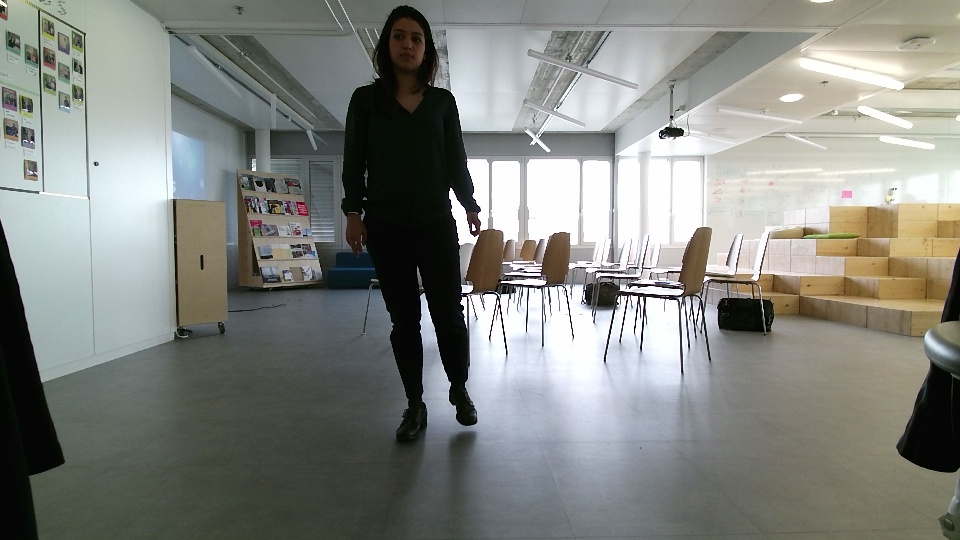

(10, 1)


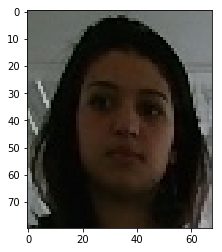

In [28]:
# Creation of an array of embedding faces that will be compared to embedding known faces with an array of corresponding
# faces (cropped images of the face detection)
unknownFace = []
unknownBoxes = []
unknownKeypoints = []

# detection parameters
minsize = 20 
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709

for x in pathUnknown: 
    display(Image(x))
    img = scipy.misc.imread(x)
    bbs, kps = align.detect_face.detect_face(img, minsize, 
                                             pnet, rnet, onet, threshold, factor)
    kps = np.asarray(kps)
    print(kps.shape)
    kps = kps.reshape([2,5,-1]).T
    
    # Check if a face has been detected
    if len(kps) != 0:  
        # add the image in the face array
        unknownFace.append(img)
        unknownBoxes.append(bbs)
        unknownKeypoints.append(kps)
        
        # Display the face only in order to check if the face was corretly detected
        margin = 32
        # Extract the position of the face from bbs
        for x0,y0,x1,y1,_ in bbs.astype(np.int32):
            x0 = np.maximum(x0 - margin//2, 0)
            y0 = np.maximum(y0 - margin//2, 0)
            x1 = np.minimum(x1 + margin//2, img.shape[1])
            y1 = np.minimum(y1 + margin//2, img.shape[0])
            plt.imshow(img[y0:y1,x0:x1])
        

In [30]:
# Computation of the embeddings for unknown faces
print('computing embeddings')
size = 160
margin = 32

# Creation of the future array of embeddings for unknown faces and 
# the corresponding cropped faces for checking purpose
unknownFaces_embs = []
unknownCropped = []

# Fill arrays
for img, bbs in zip(unknownFace, unknownBoxes):
    img_faces = []
    # Cropped faces
    for x0,y0,x1,y1,_ in bbs.astype(np.int32):
        x0 = np.maximum(x0 - margin//2, 0)
        y0 = np.maximum(y0 - margin//2, 0)
        x1 = np.minimum(x1 + margin//2, img.shape[1])
        y1 = np.minimum(y1 + margin//2, img.shape[0])
    img_faces.append(scipy.misc.imresize(img[y0:y1,x0:x1], (size, size)))
    img_faces = np.stack(img_faces)
    unknownCropped.append(img_faces)
  
    # Embeddings
    feed_dict = {
        images_in : img_faces.astype(np.float32) / 255.0,
        phase_train_in : False,
    }
    unknownFaces_embs.append(sess.run(embeddings, feed_dict))
print('done!')

computing embeddings
done!


In [41]:
# return a matrix of euclidian distance pair by pairs
dist = distance.cdist(np.vstack(unknownFaces_embs), np.vstack(knownFaces_embs))

In [45]:
# We look for the index that minimize the euclidian distance 
# for each row of the euclidian distance pair by pairs matrix
minIndex = np.apply_along_axis(np.argmin, axis=1, arr=dist)

In [58]:
(np.vstack(knownCropped)).shape

(1, 160, 160, 3)

Minimum distance : 1.26312177323


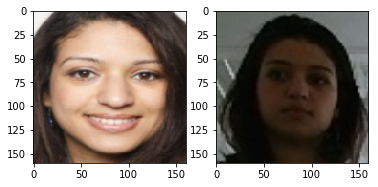

In [60]:
# Euclidian distance of the 2 first picture's faces
# compare each guess embedding faces to all the ref embedding faces
for i in range(len(minIndex)):
    print("Minimum distance : " + str(dist[i][minIndex[i]]))
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(knownCropped[i][0])
    plt.subplot(1,2,2)
    plt.imshow(unknownCropped[i][0])